In [1]:
!sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended

from latexify import latexify
latexify(columns = 2)

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
cm-super is already the newest version (0.3.4-17).
dvipng is already the newest version (1.15-1.1).
texlive-latex-extra is already the newest version (2021.20220204-1).
texlive-latex-recommended is already the newest version (2021.20220204-1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')
# Retina display
%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange

In [ ]:
!wget https://www.vincentsitzmann.com/siren/img/audio/gt_bach.wav

In [3]:
import soundfile
%matplotlib inline
!pip install pydub
from IPython.display import Audio
Audio('gt_bach.wav')

In [5]:
from pydub import AudioSegment

# Load the audio file
audio = AudioSegment.from_file("gt_bach.wav")

# Get the duration of the audio in milliseconds
duration_ms = len(audio)

# Extract the last 5 seconds
last_five_seconds_clip = audio[-5000:]  # This will slice the last 5000 ms (5 seconds)

# Save or play the trimmed audio
last_five_seconds_clip.export("last_five_seconds_clip.wav", format="wav")  # Save as wav

<_io.BufferedRandom name='last_five_seconds_clip.wav'>

In [6]:
Audio("last_five_seconds_clip.wav")

In [7]:
import torchaudio
audio, sr = torchaudio.load('last_five_seconds_clip.wav')
print(sr)
print(audio.shape)
audio = audio[0]
tm = audio.shape[0] / sr
print(f"Audio length: {tm} seconds")

44100
torch.Size([1, 220500])
Audio length: 5.0 seconds


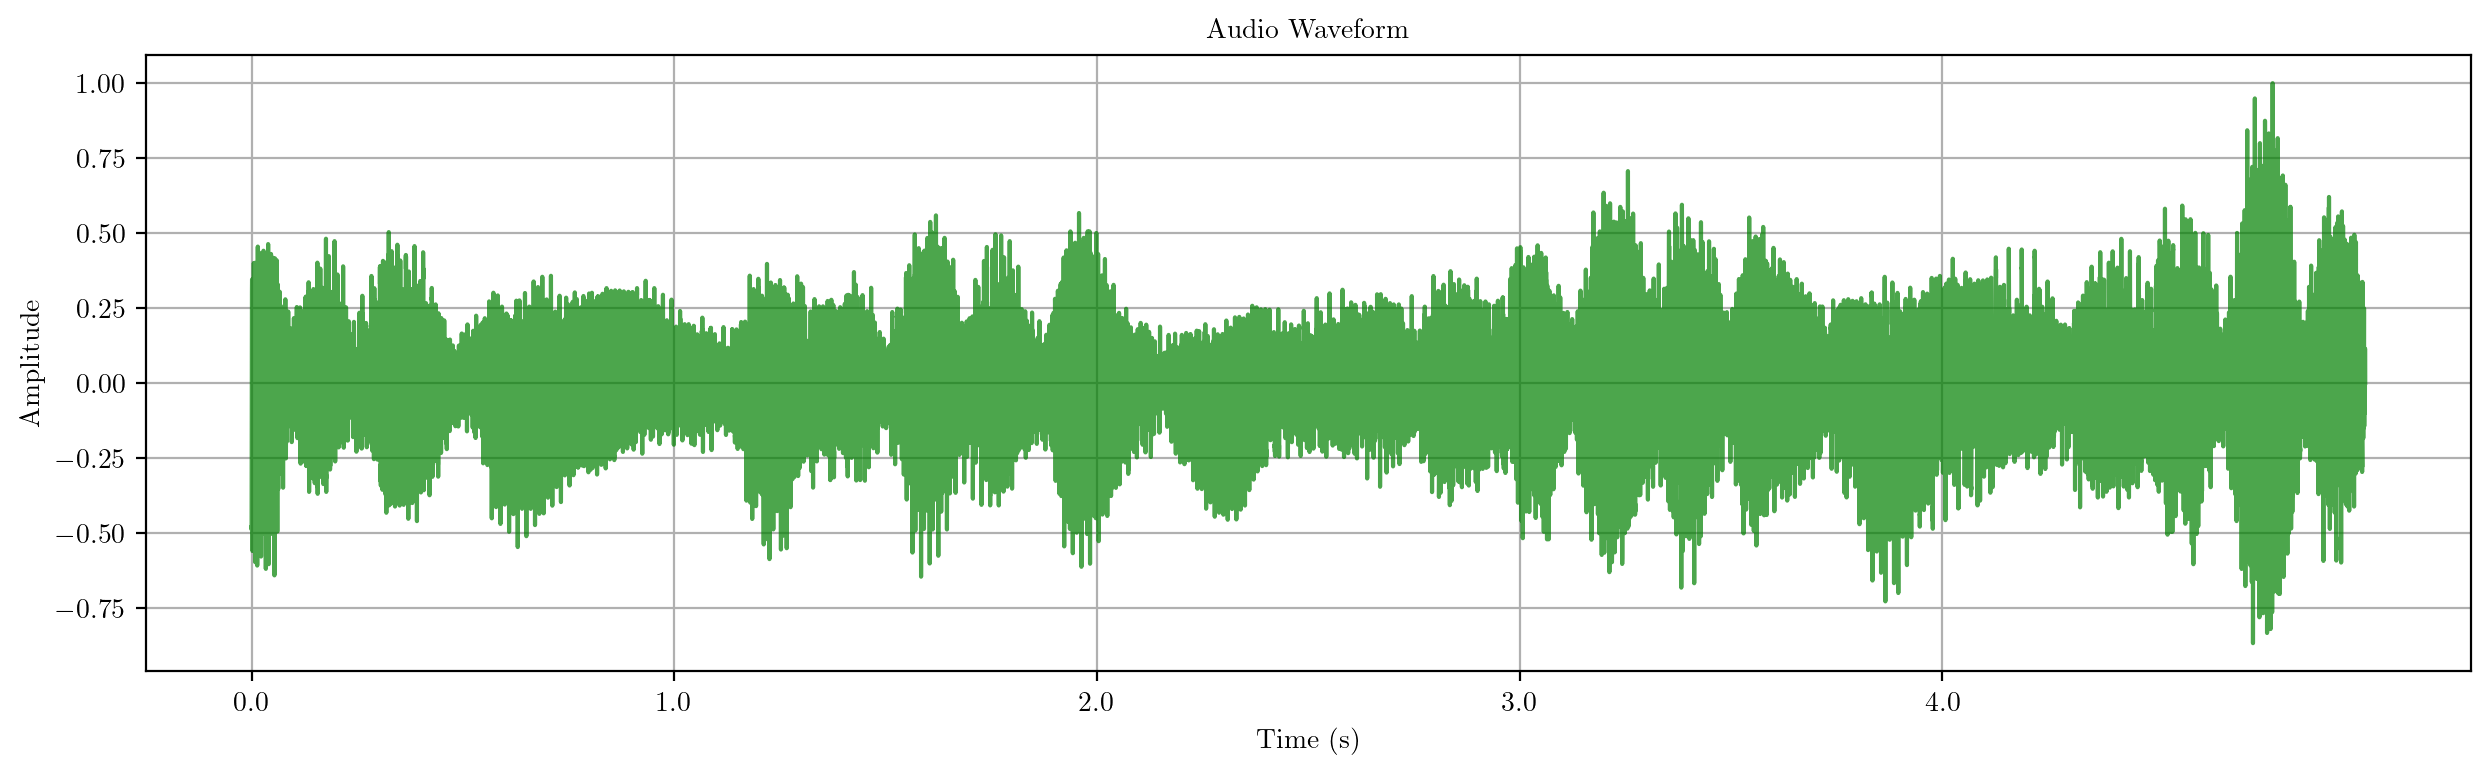

In [8]:
def audio_plot(audio, sr, clr, tl):
    plt.figure(figsize=(15, 4))
    plt.plot(audio, color = clr, alpha = 0.7)
    plt.xticks(np.arange(0, audio.shape[0], sr), np.arange(0, audio.shape[0] / sr, 1))
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title(tl)
    plt.grid()
    plt.show()
audio_plot(audio, sr, 'green', 'Audio Waveform')

In [9]:
X = torch.arange(0, len(audio)).unsqueeze(1).float()
X = X / X.max() * 200 - 100
print(X.shape)
print(X)

torch.Size([220500, 1])
tensor([[-100.0000],
        [ -99.9991],
        [ -99.9982],
        ...,
        [  99.9982],
        [  99.9991],
        [ 100.0000]])


In [10]:
from sklearn.kernel_approximation import RBFSampler

def create_rff_features(X, num_features, sigma):
    # Set a random state to the sampler for repoducibility
    rff = RBFSampler(n_components = num_features, gamma = 1 / (2 * sigma**2), random_state = 13)
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype = torch.float32)

In [17]:
num_features = 2500
sigma = 0.008

X_rff = create_rff_features(X, num_features, sigma)
print(X_rff.shape)
print(X_rff)

torch.Size([220500, 2500])
tensor([[ 0.0279,  0.0177, -0.0281,  ..., -0.0199,  0.0264, -0.0244],
        [ 0.0282,  0.0158, -0.0281,  ..., -0.0178,  0.0246, -0.0263],
        [ 0.0283,  0.0137, -0.0281,  ..., -0.0155,  0.0223, -0.0276],
        ...,
        [-0.0275, -0.0010, -0.0269,  ..., -0.0176, -0.0156, -0.0276],
        [-0.0279, -0.0035, -0.0268,  ..., -0.0153, -0.0189, -0.0282],
        [-0.0282, -0.0058, -0.0268,  ..., -0.0128, -0.0217, -0.0282]])


In [18]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_rff.numpy(), audio)

pred_audio = model.predict(X_rff.numpy())
print(pred_audio.shape)

(220500,)


In [19]:
Audio(pred_audio, rate = sr)

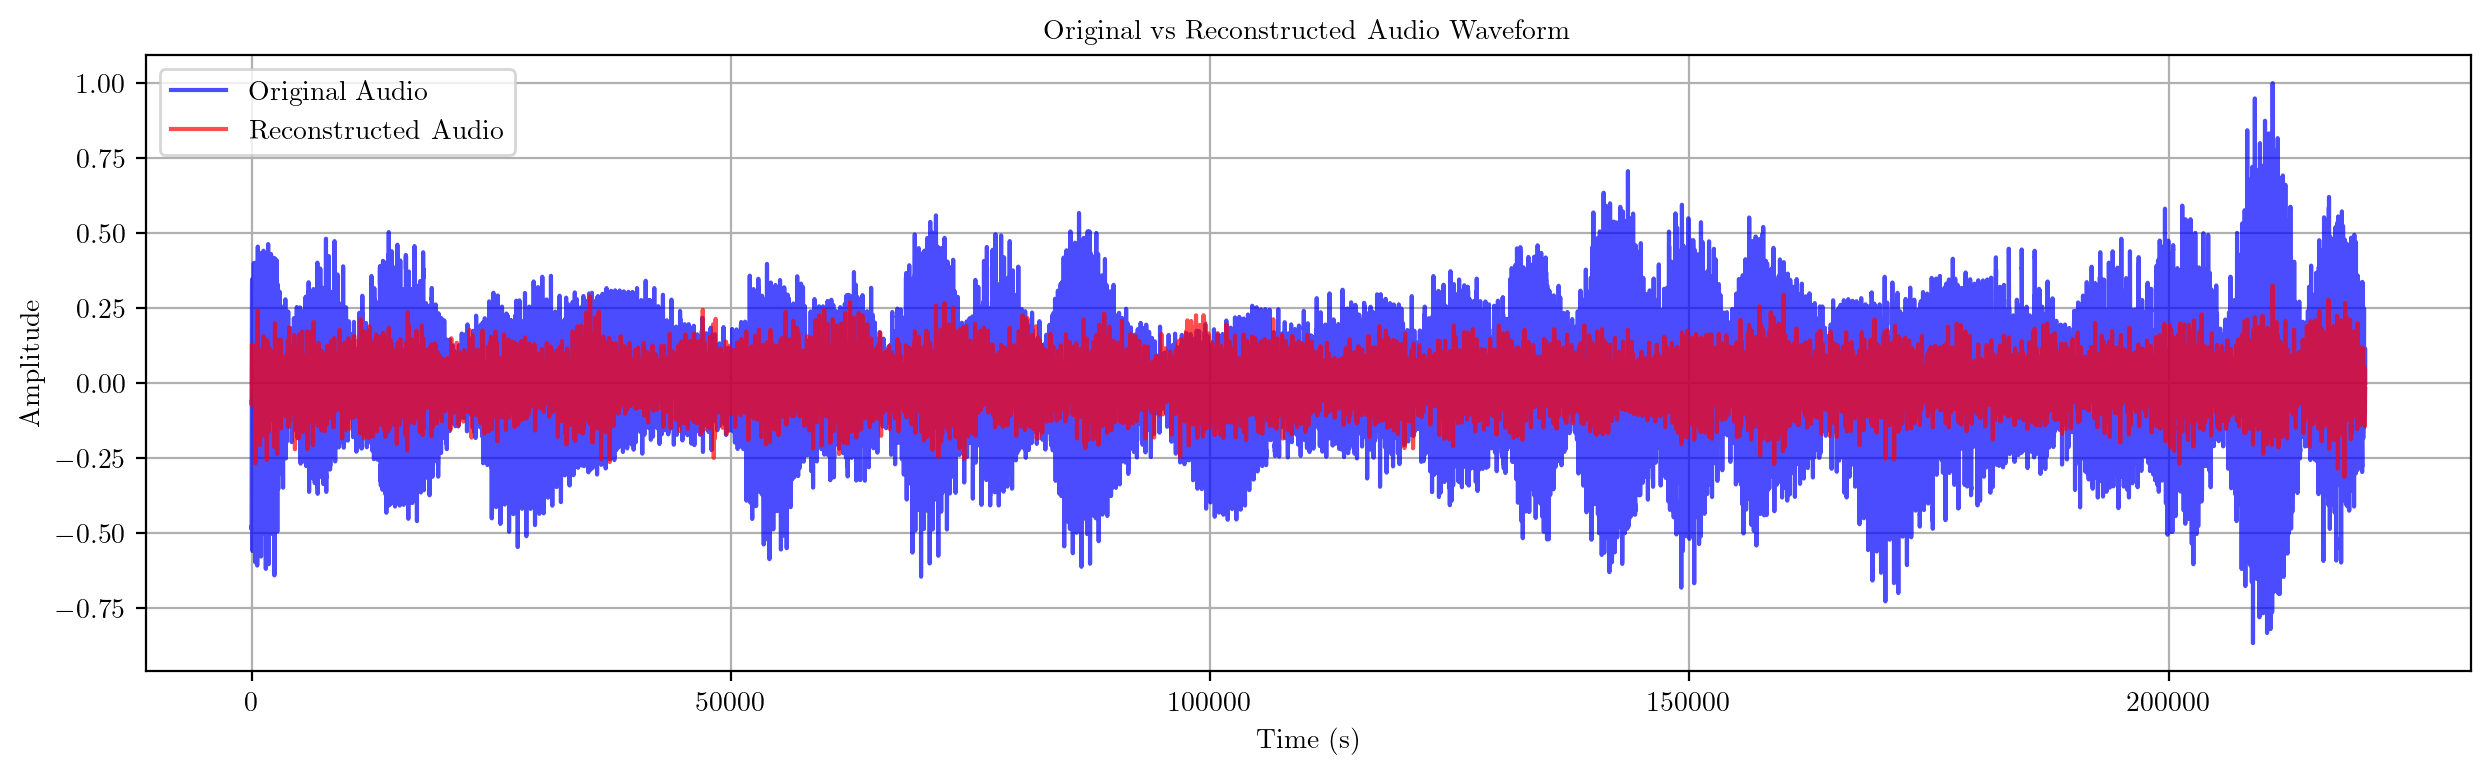

In [20]:
plt.figure(figsize=(15, 4))
plt.plot(audio, color = 'blue', alpha = 0.7, label = 'Original Audio')
plt.plot(pred_audio, color = 'red', alpha = 0.7, label = 'Reconstructed Audio')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Original vs Reconstructed Audio Waveform')
plt.grid()
plt.legend()
plt.show()

In [21]:
np.linalg.norm(pred_audio - audio.numpy()), np.linalg.norm((pred_audio - audio.numpy()), ord = 1)

(74.59323, 27126.186)

In [22]:
def compute_rmse(tensor1, tensor2):

    mse = torch.mean((tensor1 - tensor2) ** 2)
    rmse = torch.sqrt(mse)
    return rmse.item()

def calculate_snr(signal, noisy_signal):

    signal_power = torch.mean(signal ** 2)
    noise_power = torch.mean((signal - noisy_signal) ** 2)
    snr = 10 * torch.log10(signal_power / noise_power)
    return snr.item()
rmse = compute_rmse(audio, pred_audio)
snr_value = calculate_snr(audio, pred_audio)
print(f"SNR: {snr_value} dB")
print(f"RMSE: {rmse}")

SNR: 0.8460496664047241 dB
RMSE: 0.15885290503501892
